In [1]:
import pprint as pp
import os
import importlib
from transformers import AutoTokenizer
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

n_samples = 25
device = "mps"  # Set to CPU since CUDA is not available

In [2]:
df_train = pd.read_csv("train.csv").fillna(-1).iloc[:500]
df_test = pd.read_csv("test.csv")
misconception_mapping = pd.read_csv("misconception_mapping.csv").MisconceptionName.values

In [3]:
from transformers import AutoTokenizer


TOKENIZER = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Math-1.5B-Instruct")


def fromat_prompt(row, targetCol):
    PROMPT  = """{Question} 
I believe {IncorrectAnswer}.
Explain why I am wrong.
Think about {ConstructName} in your answer. 
Why is {SubjectName} relevant?
Be specific in regards to {SubjectName}.
Explain why {IncorrectAnswer} is a misconception.
Summarize my main misunderstanding in one sentance at the end.
Summarize my main misunderstanding in one sentance at the end.""" 
    
    return PROMPT.format(ConstructName=row["ConstructName"],
                     SubjectName=row["SubjectName"],
                     Question=row["QuestionText"],
                     IncorrectAnswer=row[f"Answer{targetCol}Text"],
                     CorrectAnswer=row[f"Answer{row.CorrectAnswer}Text"])

def prepare_features(train_path, mapping_path):
    TOKENIZER = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Math-1.5B-Instruct")
    misconception_mapping = pd.read_csv(mapping_path).MisconceptionName.values
    df_questions = pd.read_csv(train_path).fillna(-1).iloc[:500]

    def apply_template(prompt):
        messages = [
            {
                "role": "user", 
                "content": prompt
            }
        ]
        text = TOKENIZER.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        return text
    
    features = {}
    for idx, row in df_questions.iterrows():
        for option in ["A", "B", "C", "D"]:
            if (row.CorrectAnswer!=option) & (row[f"Misconception{option}Id"]!=-1):
                features[f"{row.QuestionId}_{option}"] = {
                    "misconception_id": [row[f"Misconception{option}Id"]], 
                    "misconception_text": misconception_mapping[int(row[f"Misconception{option}Id"])],
                    "formatted_prompt": apply_template(fromat_prompt(row, option)),  
                    "plaintext_prompt": fromat_prompt(row, option),
                    "construct_name": row["ConstructName"],
                    "question_text": row["QuestionText"]
                }

    return features

def print_feature(feature): 
    print("MISCONCEPTION: " + feature['misconception_text'] + "\n")
    print("PROMPT: \n" + feature['plaintext_prompt'])


In [4]:
features = prepare_features("train.csv", "misconception_mapping.csv")
ids = list(features.keys())

In [5]:
print_feature(features[ids[0]])

MISCONCEPTION: Confuses the order of operations, believes addition comes before multiplication 

PROMPT: 
\[
3 \times 2+4-5
\]
Where do the brackets need to go to make the answer equal \( 13 \) ? 
I believe Does not need brackets.
Explain why I am wrong.
Think about Use the order of operations to carry out calculations involving powers in your answer. 
Why is BIDMAS relevant?
Be specific in regards to BIDMAS.
Explain why Does not need brackets is a misconception.
Summarize my main misunderstanding in one sentance at the end.
Summarize my main misunderstanding in one sentance at the end.


In [6]:
#model_name = "Qwen/Qwen2.5-Math-7B-Instruct"
model_name = "Qwen/Qwen2.5-Math-1.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
for key in list(features.keys())[:n_samples]:
    feature = features[key]
    prompt = feature['plaintext_prompt']
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_new_tokens=700)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    #if response.startswith(prompt):
    #response = response[len(prompt):].strip()
    feature['response'] = response
    # Print each response
    print("--------------------------------------------------------------------------------")
    print(key)
    print(f"Misconception: {feature['misconception_text']}\n")
    print(f"Response: {response}\n")

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


--------------------------------------------------------------------------------
0_D
Misconception: Confuses the order of operations, believes addition comes before multiplication 

Response: \[
3 \times 2+4-5
\]
Where do the brackets need to go to make the answer equal \( 13 \) ? 
I believe Does not need brackets.
Explain why I am wrong.
Think about Use the order of operations to carry out calculations involving powers in your answer. 
Why is BIDMAS relevant?
Be specific in regards to BIDMAS.
Explain why Does not need brackets is a misconception.
Summarize my main misunderstanding in one sentance at the end.
Summarize my main misunderstanding in one sentance at the end. Let's analyze the given expression step by step to understand why brackets are necessary and how they affect the result.

The original expression is:
\[ 3 \times 22+4-5 \]

First, let's evaluate the expression without any brackets:
1. Perform the multiplication first:
   \[ \( 3 \times 2 = 6 \) ]
2. Now the expression 

In [8]:
df_features = pd.DataFrame.from_dict(features, orient='index').reset_index()
df_features.head(3)

,index,misconception_id,misconception_text,formatted_prompt,plaintext_prompt,construct_name,question_text,response
0,0_D,[1672.0],"Confuses the order of operations, believes add...",<|im_start|>system\nPlease reason step by step...,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,Use the order of operations to carry out calcu...,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...
1,1_A,[2142.0],Does not know that to factorise a quadratic ex...,<|im_start|>system\nPlease reason step by step...,"Simplify the following, if possible: \( \frac{...",Simplify an algebraic fraction by factorising ...,"Simplify the following, if possible: \( \frac{...","Simplify the following, if possible: \( \frac{..."
2,1_B,[143.0],Thinks that when you cancel identical terms fr...,<|im_start|>system\nPlease reason step by step...,"Simplify the following, if possible: \( \frac{...",Simplify an algebraic fraction by factorising ...,"Simplify the following, if possible: \( \frac{...",NaN


In [9]:
df_misconception_mapping = pd.read_csv("misconception_mapping.csv")

In [10]:
df_misconception_mapping.head(3)

,MisconceptionId,MisconceptionName
0,0,Does not know that angles in a triangle sum to...
1,1,Uses dividing fractions method for multiplying...
2,2,Believes there are 100 degrees in a full turn


In [11]:
# Define the number of samples you want to process and the confidence cutoff
confidence_cutoff = 0.1  # Define the cutoff for confidence (e.g., 0.5)

# Extract columns from CSV
misconception_names = df_misconception_mapping['MisconceptionName'].tolist()
explanations = df_features.head(n_samples)['response'].tolist()

# Load pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embed misconception names and explanations
misconception_embeddings = model.encode(misconception_names, convert_to_tensor=True)
explanation_embeddings = model.encode(explanations, convert_to_tensor=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
# Create a list to store all matching misconceptions and their scores for each explanation
all_matching_misconceptions = []
all_matching_misconception_ids = []

# Loop through each explanation and find all matching misconceptions
for explanation, explanation_embedding in zip(explanations, explanation_embeddings):
    # Compute cosine similarities between the current explanation and all misconceptions
    cosine_scores = util.pytorch_cos_sim(explanation_embedding, misconception_embeddings).squeeze()
    # Get all matching misconceptions and their scores above the confidence cutoff
    sorted_indices = cosine_scores.argsort(descending=True)
    matching_misconceptions = [(misconception_names[idx], cosine_scores[idx].item()) for idx in sorted_indices if cosine_scores[idx].item() >= confidence_cutoff]
    all_matching_misconceptions.append(matching_misconceptions)
    all_matching_misconception_ids.append(sorted_indices.tolist())

In [13]:
# Assuming df is your DataFrame and all_matching_misconceptions is a dictionary or list structure
# Create new columns for storing the matching misconceptions and match positions
# Ensure columns exist in the DataFrame
df_features['matching_misconceptions'] = None  # Initializes the column with None
df_features['matching_misconception_ids'] = None  # Initializes the column with None
df_features['match_position'] = None  # Initializes the column with None
match_numbers = []

# Process each row in the DataFrame
for idx, feature in df_features.head(n_samples).iterrows():
    actual_misconception = feature['misconception_text']
    match_position = None

    # Access all matching misconceptions using the correct index
    for position, (misconception, confidence) in enumerate(all_matching_misconceptions[idx]):
        if misconception == actual_misconception and match_position is None:
            match_position = position + 1  # Adding 1 to make it 1-based index for user readability

    # Add the all_matching_misconceptions[idx] and match_position to the DataFrame
    df_features.at[idx, 'matching_misconceptions'] = all_matching_misconceptions[idx]
    df_features.at[idx, 'matching_misconception_ids'] = ' '.join(map(str, all_matching_misconception_ids[idx]))
    df_features.at[idx, 'match_position'] = match_position
    if match_position is not None:
        match_numbers.append(match_position)
    else:
        match_numbers.append(-1)

In [14]:
average = sum(match_numbers) / len(match_numbers)
print("The average is:", average)

The average is: 71.0


In [15]:
df_features[["index", "matching_misconception_ids"]].head(n_samples).to_csv("submission.csv", index=False)

In [16]:
df_features[["index", "misconception_id"]].to_parquet("label.parquet", index=False)

In [17]:
import numpy as np

def apk(actual, predicted, k=25):
    """
    Computes the average precision at k.
    
    This function computes the average prescision at k between two lists of
    items.
    
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
        
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=25):
    
    """
    Computes the mean average precision at k.
    
    This function computes the mean average prescision at k between two lists
    of lists of items.
    
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
        
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [18]:
pd.read_parquet("label.parquet")["misconception_id"].head(3)

0    [1672.0]
1    [2142.0]
2     [143.0]
Name: misconception_id, dtype: object

In [19]:
import pandas as pd
predicted = pd.read_csv("submission.csv")["matching_misconception_ids"].head(n_samples).apply(lambda x: [int(y) for y in x.split()])
label = pd.read_parquet("label.parquet")["misconception_id"]
mapk_score = mapk(label, predicted)
average = sum(match_numbers) / len(match_numbers)

In [20]:
print("Validation: ", mapk_score)
print("\nAverage answer ranking: " + str(average))
print("\nAll correct answer rankings: " + str(match_numbers))

Validation:  0.0

Average answer ranking: 71.0

All correct answer rankings: [28, 114]


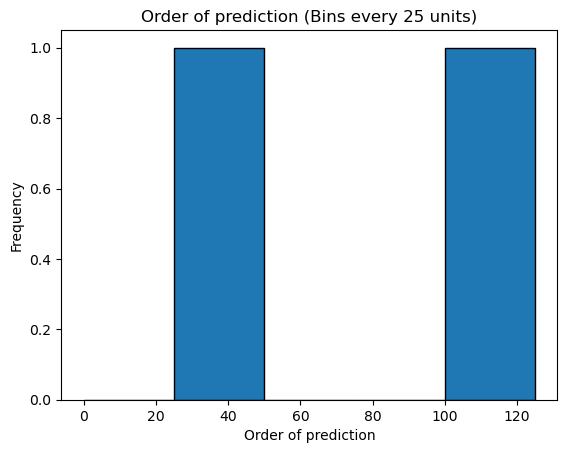

In [21]:
# Define bins to be every 25 units
bins = np.arange(0, max(match_numbers) + 25, 25)  # Bins from 0 to the max value in steps of 25

# Plot histogram
plt.hist(match_numbers, bins=bins, edgecolor='black')

# Add title and labels
plt.title('Order of prediction (Bins every 25 units)')
plt.xlabel('Order of prediction')
plt.ylabel('Frequency')

# Show the plot
plt.show()